In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import interpolate

In [14]:
def spectrum(R,h,hdu): #esta rutina es para leer los espectros en el punto de la galaxia que querais
    n = len(hdu)
    primary_header = hdu[0].header
    
    Rmin = primary_header['rmin']
    Rmax = primary_header['rmax']
    dimR = primary_header['dimR']
    stepR = round((Rmax-Rmin)/dimR,1)
    
    zmin = primary_header['zmin'] 
    zmax = primary_header['zmax']
    dimz = primary_header['dimz']
    stepz = round((zmax-zmin)/dimz,2)
    
    R_i = int(np.round((R-Rmin)/stepR))
    h_i = int(np.round((h-zmin)/stepz))

    dm_pos = hdu[1].data[h_i,R_i,:]
    dm_e = hdu[2].data[h_i,R_i,:]
    
    return dm_pos, dm_e

In [15]:
#file = '../../Descargas/isothermal.fits.gz'#el nombre del archivo que queramos leer
file = 'mumu_1000gev_NFW.fits.gz'
hdulist = fits.open(file)

prihdr = hdulist[0].header
n_ext = len(hdulist)

table_hdu = hdulist[0]
table_header = table_hdu.header

emin   = table_header['ekmin']
ek_fac = table_header['ekin_fac']
dimE   = table_header['dimE']

E = [emin*(ek_fac**i) for i in range(0,dimE)]
E = np.array(E)

Rmin = table_header['rmin'] #kpc
Rmax = table_header['rmax']
dimR = table_header['dimR']

R = np.linspace(Rmin,Rmax,dimR)
stepR = round((Rmax-Rmin)/dimR,1)

zmin = table_header['zmin'] 
zmax = table_header['zmax']
dimz = table_header['dimz']
z = np.linspace(zmin,zmax,dimz)
stepz = round((zmax-zmin)/dimz,2)

print('Rmin =',Rmin,', Rmax =',Rmax,', stepR =',stepR)
print('zmin =',zmin,', zmax =',zmax,', stepz =',stepz)

Rmin = 0.0 , Rmax = 12.0 , stepR = 0.1
zmin = -18.0 , zmax = 18.0 , stepz = 0.3


In [16]:
pos, e = spectrum(8.3, 0, hdulist)

In [17]:
# aqui tenemos algunas funciones utiles
Elog = np.log(E)
phi = 0.58#el parametro de la modulacion solar

def lepton_modulation(E, Elog, spectrum, potential, m):#modulación solar
    dimE = len(E)
    spectrum_mod = np.zeros(int(dimE))
    A = ((E + m)**2 - m**2) / (((E + m) + potential)**2 - m**2)    
    F = interpolate.InterpolatedUnivariateSpline(Elog, spectrum)
    Elog_shifted = np.zeros(dimE)
    for i in range(dimE):
        Elog_shifted[i] = np.log(E[i] + potential)
    spectrum_mod = A * F(Elog_shifted)
    return spectrum_mod

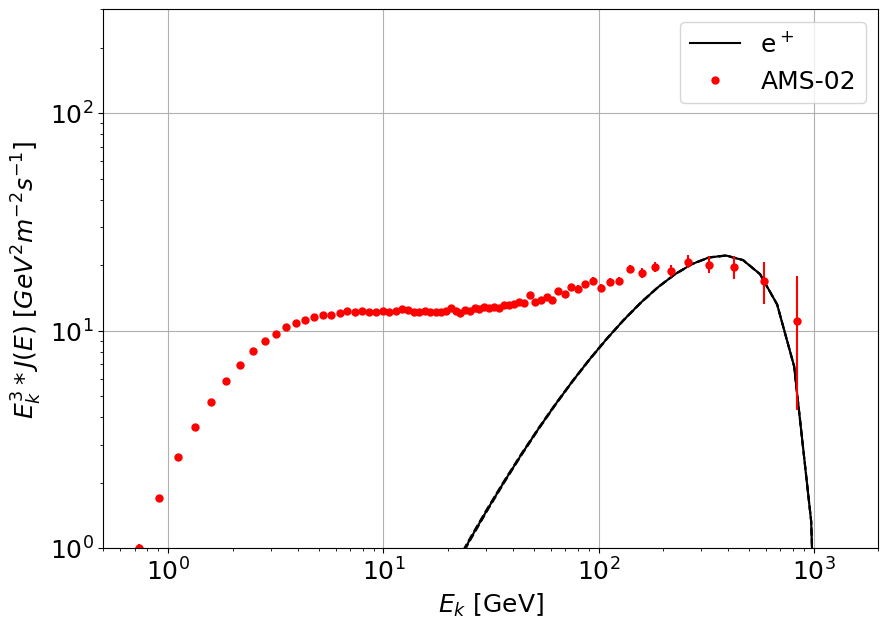

In [28]:
#POSITRONES
m_e = 0.51099e-3

sigmav0 = 1e-24

sigmav_new = 2e-20

ratio = sigmav_new/sigmav0

pos0 = lepton_modulation(E, Elog, ratio*pos, phi, m_e)
pos1 = lepton_modulation(E, Elog, ratio*pos, phi-0.1, m_e)
pos2 = lepton_modulation(E, Elog, ratio*pos, phi+0.1, m_e)

e0 = lepton_modulation(E, Elog, ratio*e, phi, m_e)
e1 = lepton_modulation(E, Elog, ratio*e, phi-0.1, m_e)
e2 = lepton_modulation(E, Elog, ratio*e, phi+0.1, m_e)


pos_exp = np.loadtxt('positron_data.txt',usecols=[5,8,9])
E_pos = pos_exp[:,0]
flux_pos = pos_exp[:,1]
err_pos = pos_exp[:,2]

plt.figure(figsize=(10,7))
plt.loglog(E,pos0*E**3,'k',label=r'e$^+$')
plt.loglog(E,pos1*E**3,'k--')
plt.loglog(E,pos2*E**3,'k--')
plt.fill_between(E,pos1*E**3,pos2*E**3,facecolor = 'lightgray')
#plt.loglog(E,e*E**3,'b',label=r'e$^-$')
#plt.loglog(E,e1*E**3,'b--')
#plt.loglog(E,e2*E**3,'b--')
#plt.fill_between(E,e1*E**3,e2*E**3,facecolor = 'lightgray')
plt.loglog(E_pos,flux_pos*(E_pos**3),'ro',markersize=5,label = 'AMS-02')
plt.errorbar(E_pos,flux_pos*(E_pos**3), yerr = err_pos*(E_pos**3), fmt = 'none',ecolor = 'r')

plt.legend(fontsize = 18)
plt.ylabel(r'$E_k^3 * J(E)\;[GeV^{2} m^{-2} s^{-1}]$', fontsize = 18)
plt.xlabel(r'$E_k$ [GeV]', fontsize = 18)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylim(1e0,3e2)
plt.xlim(5e-1,2e3)
plt.grid()
plt.show()